Goal: Train an XGBoost model to predict $k_{eff}$ and validate its performance.

1. Setup and Loading Data

First, we'll import the necessary libraries. In a real-world scenario, you might load the scaled data from files. For this demonstration, we will quickly regenerate the variables from Notebook 2's output.

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# --- Regenerate Data from Notebook 2 ---
# Load the original dataset
df = pd.read_csv('reactor_simulations.csv')

# Separate features and target
X = df.drop('keff', axis=1)
y = df['keff']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data loaded and preprocessed.")

Data loaded and preprocessed.


2. Train the XGBoost Model

Now, we will initialize and train the XGBoost Regressor. XGBoost is an excellent choice for this type of problem due to its high performance and efficiency with structured data.



In [12]:
# Initialize the XGBoost Regressor model
# These hyperparameters are a good starting point.
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

print("Training the XGBoost model...")
# Train the model on the scaled training data
xgb_model.fit(X_train_scaled, y_train)

print("Model training complete.")

Training the XGBoost model...
Model training complete.


3. Evaluate Model Accuracy

With the model trained, we'll use it to make predictions on the unseen test set and calculate key performance metrics.

a. R-squared : The proportion of the variance in the target variable that is predictable from the features. A value closer to 1.0 is better.

b. Root Mean Squared Error (RMSE): The standard deviation of the prediction errors (residuals). It's in the same units as the target ($k_{eff}$), so a lower value is better.



In [14]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test_scaled)

# Calculate performance metrics
r2 = r2_score(y_test, y_pred)
# Calculate Mean Squared Error first
mse = mean_squared_error(y_test, y_pred)
# Then take the square root to get RMSE
rmse = np.sqrt(mse)

print(f"--- Model Performance on Test Set ---")
print(f"R-squared (R²): {r2:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")

--- Model Performance on Test Set ---
R-squared (R²): 0.997213
Root Mean Squared Error (RMSE): 0.011044


4. Visualize Performance

A parity plot is the best way to visualize a regression model's performance. It plots the model's predicted values against the actual (simulated) values. A perfect model would have all points lying on a straight 45-degree line.



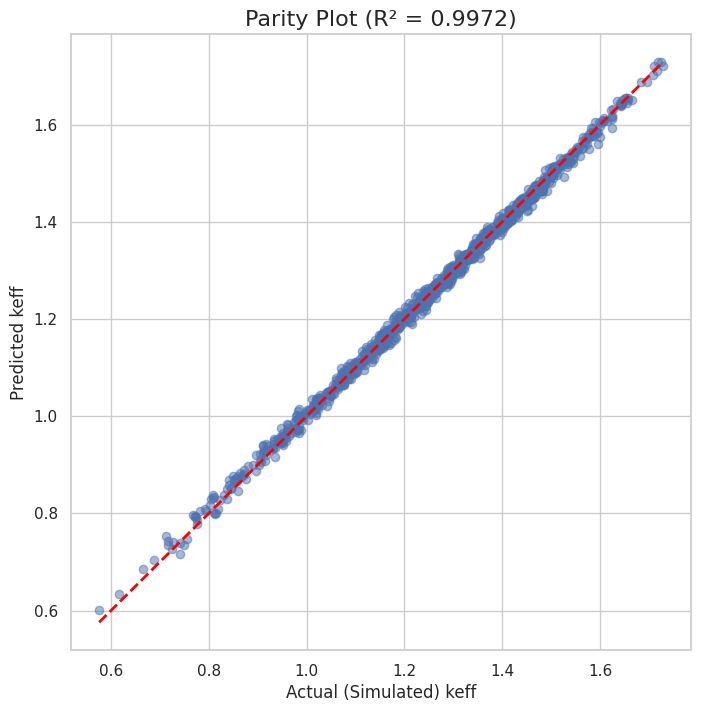

In [15]:
# Create the parity plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2)
plt.xlabel('Actual (Simulated) keff')
plt.ylabel('Predicted keff')
plt.title(f'Parity Plot (R² = {r2:.4f})', fontsize=16)
plt.grid(True)
plt.show()

5. Interpret the Model (Feature Importance)

Let's see which design parameters the model found most influential in predicting $k_{eff}$. This helps validate that the model is learning physically meaningful relationships.



/tmp/ipython-input-1820712815.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


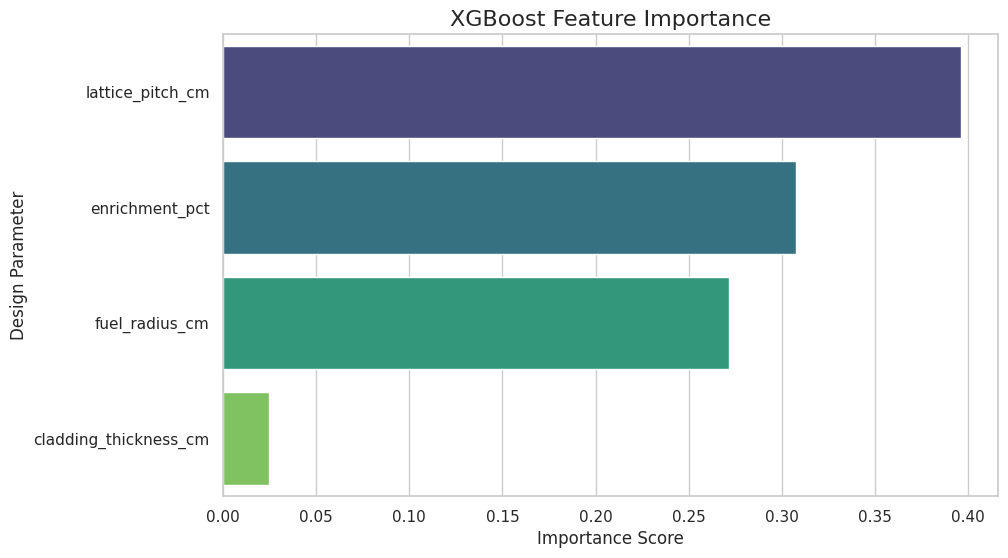

In [16]:
# Get feature importances from the trained model
importances = xgb_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Design Parameter')
plt.show()